## 2.1 E-epidemiology data exhibit significant correlation with disease prevalence 

In [1]:
import sys
sys.path.append(r'D:/Stata17/utilities')
from pystata import config
config.init('mp')


  ___  ____  ____  ____  ____ ©
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       MP—Parallel Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Single-user 2-core  perpetual
Serial number: 501806366048
  Licensed to: 123
               123

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. More than 2 billion observations are allowed; see help obs_advice.
      3. Maximum number of variables is set to 5,000; see help set_maxvar.


In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import io, sys
import warnings
import maya
import scipy
from scipy.stats import pearsonr
from scipy import stats
from statsmodels.tsa.stattools import grangercausalitytests
warnings.filterwarnings('ignore')
import os,sys,stata_setup
from pystata import stata

def save_output(filename):
    def decorator(func):
        def wrapper(*args, **kwargs):
            output = io.StringIO()
            original_stdout = sys.stdout 
            sys.stdout = output
            
            try:
                result = func(*args, **kwargs)
                output_text = output.getvalue()
                with open(filename, 'w') as f:
                    f.write(output_text)
                sys.stdout = original_stdout
                print(output_text)
                return result
            finally:
                if sys.stdout is not original_stdout:
                    sys.stdout = original_stdout
        return wrapper
    return decorator
source='baidu'
MAXLAG=14
maxlag=MAXLAG
IRF_PERIODS=90
BAIDU_DIFF=True
BAIDU_LOG='all_log'
GOOGLE_DIFF=BAIDU_DIFF
GOOGLE_LOG=BAIDU_LOG

In [3]:
df = pd.read_excel('../../data/baidu/comorbidities/comorbidity.xlsx')

# Convert date column to datetime using delorean
def parse_date(date_str):
    return maya.parse(date_str).datetime()

# Convert the 'date' column to datetime, considering different formats


df['date'] = df['date'].astype(str).apply(parse_date)


time_features = {
    'day': ('to_period', 'D'),
    'week': ('to_period', 'W'),
    'month': ('to_period', 'M'),
    'week_of_year': ('isocalendar', 'week'),
    'month_of_year': ('month', None),
    'year': ('year', None)
}

for col, (func, param) in time_features.items():
    if func == 'to_period':
        df[col] = df['date'].dt.to_period(param)
    elif func == 'isocalendar':
        df[col] = getattr(df['date'].dt.isocalendar(), param)
    else:
        df[col] = getattr(df['date'].dt, func)

df['all_log'] = np.log(df['all'] + 1)
df['keyword'] = df['keyword'].apply(lambda x: x.lower() if isinstance(x, str) else x)

df.head()


,keyword,date,Scope,all,pc,wise,day,week,month,week_of_year,month_of_year,year,all_log
0,epilepsy,2015-01-01 00:00:00+00:00,Nationwide,2555,806,1749,2015-01-01,2014-12-29/2015-01-04,2015-01,1,1,2015,7.846199
1,epilepsy,2015-01-02 00:00:00+00:00,Nationwide,2626,861,1765,2015-01-02,2014-12-29/2015-01-04,2015-01,1,1,2015,7.873598
2,epilepsy,2015-01-03 00:00:00+00:00,Nationwide,2610,817,1793,2015-01-03,2014-12-29/2015-01-04,2015-01,1,1,2015,7.867489
3,epilepsy,2015-01-04 00:00:00+00:00,Nationwide,2736,935,1801,2015-01-04,2014-12-29/2015-01-04,2015-01,1,1,2015,7.914618
4,epilepsy,2015-01-05 00:00:00+00:00,Nationwide,2780,923,1857,2015-01-05,2015-01-05/2015-01-11,2015-01,2,1,2015,7.930566


In [4]:
df_epi=pd.read_excel('../../data/baidu/GBD/GBD_china.xlsx')
df_epi['cause_name']=df_epi['cause_name'].apply(lambda x: x.lower() if isinstance(x, str) else x)
final_df=pd.DataFrame(columns=['keyword','country','measure_name','metric_name','Search_value_is_or_not_original','GBD_value_is_or_not_original','pearson','p_value','pearson significance','pearson strong correlation'])
	
df_grouped= df.groupby(['keyword', 'year']).agg({
    'all': 'sum'
}).reset_index()
df_grouped=df_grouped[['keyword','year','all']]
df_grouped['all_log']=np.log(df_grouped['all']+1)
df_grouped.drop_duplicates(inplace=True)
df_grouped.sort_values(by=['keyword','year'],inplace=True)

name_tar1='China'
for name_tar2 in ['Prevalence','Incidence']:
    for name_tar3 in ['Number','Percent','Rate']:

        bool_target1=df_epi['location_name']==name_tar1
        bool_target2=df_epi['measure_name']==name_tar2
        bool_target3=df_epi['metric_name']==name_tar3

        df_target=df_epi[bool_target1 & bool_target2 & bool_target3].copy()
        df_target=df_target[['cause_name','year','val']]
        # print(df_target['cause_name'].unique())
        df_target.columns=['keyword','year','comorbidity_all'] 

        df_target['comorbidity_all_log']=np.log(df_target['comorbidity_all']+1)
        df_target.drop_duplicates(inplace=True)
        df_target.sort_values(by=['keyword','year'],inplace=True)

        df1=pd.merge(df_target,df_grouped, on=['year','keyword'],how='inner')
        # print(df1.shape)
        df1.sort_values(by='year',inplace=True)
        df1.drop_duplicates(inplace=True)
        # print(df1)
        print(df1.keyword.unique())
        for Search_value_is_or_not_original in ['Yes','No']:
            for GBD_value_is_or_not_original in ['Yes','No']:
                def calculate_corr_and_pval(group):
                    if Search_value_is_or_not_original=='Yes':
                        x=group['all']
                    else:
                        x=group['all_log']
                    if GBD_value_is_or_not_original=='Yes':
                        y=group['comorbidity_all']
                    else:
                        y=group['comorbidity_all_log']

                    corr, pval = pearsonr(x, y)
                    return pd.Series({'correlation': corr, 'p_value': pval})

                results = df1.groupby('keyword').apply(calculate_corr_and_pval)
                results=results.to_dict()
                # print(results)
                for key in results['correlation'].keys():
                    # print(results['p_value'][key])
                    item={}
                    item['keyword']=key
                    item['country']=name_tar1
                    item['measure_name']=name_tar2
                    item['metric_name']=name_tar3
                    item['Search_value_is_or_not_original']=Search_value_is_or_not_original
                    item['GBD_value_is_or_not_original']=GBD_value_is_or_not_original
                    item['pearson']=results['correlation'][key]
                    item['p_value']=results['p_value'][key]
                    if item['p_value']<0.05:
                        item['pearson significance']='Y'
                    else:
                        item['pearson significance']=''
                    if item['pearson']>0.7:
                        item['pearson strong correlation']='Y'
                    else:
                        item['pearson strong correlation']=''
                    if name_tar3 in ['Percent','Rate']:
                        if GBD_value_is_or_not_original=='No':
                            continue
                    final_df = pd.concat([final_df, pd.DataFrame([item])], ignore_index=True)

final_df.sort_values(by=['measure_name','metric_name'],inplace=True)
final_df
output_file_path = os.path.join('./', 'ep_comorbidity_and_GBD_pearson.csv')
final_df.to_csv(output_file_path, index=False, encoding='utf-8-sig')

['anxiety disorder' 'attention deficit hyperactivity disorder'
 'autism spectrum disorder' 'bipolar disorder' 'depression' 'epilepsy'
 'migraine']
['anxiety disorder' 'attention deficit hyperactivity disorder'
 'autism spectrum disorder' 'bipolar disorder' 'depression' 'epilepsy'
 'migraine']
['anxiety disorder' 'attention deficit hyperactivity disorder'
 'autism spectrum disorder' 'bipolar disorder' 'depression' 'epilepsy'
 'migraine']
['anxiety disorder' 'attention deficit hyperactivity disorder'
 'autism spectrum disorder' 'bipolar disorder' 'depression' 'epilepsy'
 'migraine']
['anxiety disorder' 'attention deficit hyperactivity disorder'
 'autism spectrum disorder' 'bipolar disorder' 'depression' 'epilepsy'
 'migraine']
['anxiety disorder' 'attention deficit hyperactivity disorder'
 'autism spectrum disorder' 'bipolar disorder' 'depression' 'epilepsy'
 'migraine']


In [5]:
name_tar1='China'
name_tar2='Prevalence'
name_tar3='Number'

bool_target1=df_epi['location_name']==name_tar1
bool_target2=df_epi['measure_name']==name_tar2
bool_target3=df_epi['metric_name']==name_tar3

df_target=df_epi[bool_target1 & bool_target2 & bool_target3]
df_target=df_target[['cause_name','year','val']]
df_target.columns=['keyword','year','comorbidity_all'] 
df_target['comorbidity_all_log']=np.log(df_target['comorbidity_all']+1)
df_target.sort_values(by='year',inplace=True)
df_target.drop_duplicates(inplace=True)
df_target

,keyword,year,comorbidity_all,comorbidity_all_log
0,depression,2015,4.883071e+07,17.703870
21,migraine,2015,1.790405e+08,19.003122
42,bipolar disorder,2015,2.810943e+06,14.849031
63,autism spectrum disorder,2015,8.696872e+06,15.978474
84,anxiety disorder,2015,4.412621e+07,17.602564
105,attention deficit hyperactivity disorder,2015,2.387113e+07,16.988181
126,epilepsy,2015,2.746544e+06,14.825854
45,bipolar disorder,2016,2.819495e+06,14.852069
66,autism spectrum disorder,2016,8.775065e+06,15.987425
87,anxiety disorder,2016,4.444819e+07,17.609835


In [6]:
df_grouped= df.groupby(['keyword', 'year']).agg({'all': 'sum'}).reset_index()

df1 = df_target.merge(df_grouped, on=['year','keyword'], how='inner')
df1.sort_values(by='year',inplace=True)
df1.drop_duplicates(inplace=True)
df1['all_log']=np.log(df1['all']+1)

def calculate_corr_and_pval(group,log_suffix=False):
    if log_suffix:
        corr, pval = pearsonr(group['all_log'], group['comorbidity_all_log'])
    else:
        corr, pval = pearsonr(group['all'], group['comorbidity_all'])
    return pd.Series({'correlation': corr, 'p_value': pval})

results = df1.groupby('keyword').apply(calculate_corr_and_pval)
results_log = df1.groupby('keyword').apply(calculate_corr_and_pval,log_suffix=True)
print("year level comorbidity pearson correlation【origin】",results)
print("year level comorbidity pearson correlation【log】",results_log)

year level comorbidity pearson correlation【origin】                                           correlation   p_value
keyword                                                        
anxiety disorder                             0.763691  0.045692
attention deficit hyperactivity disorder     0.105938  0.821161
autism spectrum disorder                     0.824592  0.022464
bipolar disorder                             0.901544  0.005537
depression                                   0.253771  0.582923
epilepsy                                     0.748879  0.052734
migraine                                     0.772007  0.041980
year level comorbidity pearson correlation【log】                                           correlation   p_value
keyword                                                        
anxiety disorder                             0.735402  0.059623
attention deficit hyperactivity disorder     0.103491  0.825247
autism spectrum disorder                     0.820740  0.023666
bipol

In [ ]:

year_0_values = df1[df1['year'] == 2015].iloc[0]


df1['all_log_adjusted'] = df1['all_log'] - year_0_values['all_log']
df1['comorbidity_all_log_adjusted'] = df1['comorbidity_all_log'] - year_0_values['comorbidity_all_log']

df1.sort_values(by='year', inplace=True)
df1.drop_duplicates(inplace=True)

df1.head()

,keyword,year,comorbidity_all,comorbidity_all_log,all,all_log,all_log_adjusted,comorbidity_all_log_adjusted
0,depression,2015,4.883071e+07,17.703870,2510215,14.735879,0.000000,0.000000
1,migraine,2015,1.790405e+08,19.003122,901829,13.712181,-1.023698,1.299252
2,bipolar disorder,2015,2.810943e+06,14.849031,226633,12.331092,-2.404788,-2.854839
3,autism spectrum disorder,2015,8.696872e+06,15.978474,360865,12.796262,-1.939617,-1.725396
4,anxiety disorder,2015,4.412621e+07,17.602564,864142,13.669494,-1.066386,-0.101306


In [8]:
df_filtered=df1.copy()
output_file_path = os.path.join('./', 'search_and_GBD.csv')
df1[['keyword','year','all','all_log','comorbidity_all','comorbidity_all_log']].rename(columns={'all_log':'search_log','comorbidity_all_log':"prevalence_log",'all':'search','comorbidity_all':"prevalence"}).to_csv(output_file_path, index=False, encoding='utf-8-sig')




In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Assume your data is stored in a CSV file
csv_file_path = "./search_and_GBD.csv"  # Replace with your actual data path
pic_file_path = "./pics/"  # Replace with your actual output image path
if not os.path.exists(pic_file_path):
    os.makedirs(pic_file_path)

# Load data
df = pd.read_csv(csv_file_path)

df_pearson = pd.read_csv('./ep_comorbidity_and_GBD_pearson.csv')

# Keyword translation mapping (ADHD removed)
keyword_translation = {
    'migraine': 'Migraine',
    'epilepsy': 'Epilepsy',
    'anxiety disorder': 'Anxiety disorder',
    'depression': 'Depression',
    'bipolar disorder': 'Bipolar disorder',
    # 'attention deficit hyperactivity disorder': 'Attention deficit hyperactivity disorder(ADHD)',
    'autism spectrum disorder': 'Autism spectrum disorder(ASD)'
}

# Pearson correlation and P-value data
# Read CSV file
df_pearson = pd.read_csv('./ep_comorbidity_and_GBD_pearson.csv')

# Filter data using boolean indexing
df_pearson = df_pearson[
    (df_pearson['measure_name'] == 'Prevalence') &
    (df_pearson['metric_name'] == 'Number') &
    (df_pearson['Search_value_is_or_not_original'] == 'No') &
    (df_pearson['GBD_value_is_or_not_original'] == 'No')
]

# Prepare correlation data manually by row index
correlation_data = {
    'migraine': {'correlation': df_pearson[6:7]['pearson'].iloc[0], 'p_value': df_pearson[6:7]['p_value'].iloc[0]},
    'bipolar disorder': {'correlation': df_pearson[3:4]['pearson'].iloc[0], 'p_value': df_pearson[3:4]['p_value'].iloc[0]},
    # 'attention deficit hyperactivity disorder': {'correlation': df_pearson[1:2]['pearson'].iloc[0], 'p_value': df_pearson[1:2]['p_value'].iloc[0]},
    'depression': {'correlation': df_pearson[4:5]['pearson'].iloc[0], 'p_value': df_pearson[4:5]['p_value'].iloc[0]},
    'anxiety disorder': {'correlation': df_pearson[0:1]['pearson'].iloc[0], 'p_value': df_pearson[0:1]['p_value'].iloc[0]},
    'epilepsy': {'correlation': df_pearson[5:6]['pearson'].iloc[0], 'p_value': df_pearson[5:6]['p_value'].iloc[0]},
    'autism spectrum disorder': {'correlation': df_pearson[2:3]['pearson'].iloc[0], 'p_value': df_pearson[2:3]['p_value'].iloc[0]}
}

# Filter the main dataframe
df_filtered = df[df['keyword'].isin(keyword_translation.keys())]

# Add translated keyword column
df_filtered['translated_keyword'] = df_filtered['keyword'].map(keyword_translation)

# Set global font to Arial
plt.rcParams['font.family'] = 'Arial'

# Create a panel figure (2 rows × 3 columns layout, fits 5 subplots)
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True)  # Share x-axis
fig.subplots_adjust(hspace=0.2, wspace=0.4)  # Adjust spacing between subplots

# Initialize global legend handles and labels
global_handles = []
global_labels = []

# Loop through each keyword and plot its subplot
for idx, keyword in enumerate(keyword_translation.keys()):
    # Filter data for the keyword
    data = df_filtered[df_filtered['keyword'] == keyword]
    translated_keyword = keyword_translation[keyword]
    
    # Determine the subplot location
    ax1 = axes[idx // 3, idx % 3]

    # Plot search index data
    line1, = ax1.plot(data['year'], data['search_log'], label="Search engine index (log)", color='#4A6FA5', marker='o', linewidth=2, zorder=2)
    ax1.tick_params(axis='y', labelsize=10)
    ax1.tick_params(axis='x', labelsize=10)

    # Plot GBD prevalence data (on right y-axis)
    ax2 = ax1.twinx()
    line2, = ax2.plot(data['year'], data['prevalence_log'], label="GBD number of cases (log)", color='#F18C54', linestyle='--', marker='x', linewidth=2, zorder=2)
    ax2.tick_params(axis='y', labelsize=10)

    # Format right y-axis with 3 decimal places
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.3f}'))

    # Set subplot title
    ax1.set_title(f'{translated_keyword}', fontsize=14)

    # Add Pearson correlation and p-value info
    correlation = correlation_data[keyword]['correlation']
    p_value = correlation_data[keyword]['p_value']
    ax2.text(
        0.95, 0.05,  # Position: bottom-right
        f'Corr: {correlation:.3f}\nP: {p_value:.2e}', 
        transform=ax2.transAxes,
        fontsize=10, 
        ha='right',
        va='bottom',
        bbox=dict(boxstyle='round,pad=0.3', edgecolor='gray', facecolor='white', alpha=0.7),
        zorder=100  # Make sure it's on top
    )

    # Collect legend handles and labels (only once)
    if idx == 0:
        global_handles.extend([line1, line2])
        global_labels.extend(["Search engine", "GBD"])

# Hide any unused subplots
total_plots = len(keyword_translation)
for idx in range(total_plots, 6):  # 2×3 layout = 6 subplots total
    fig.delaxes(axes[idx // 3, idx % 3])  # Remove extra subplot

# Add shared Y-axis labels for each row
fig.text(0.07, 0.70, 'Search engine index (log)', va='center', rotation='vertical', fontsize=14)  # Row 1
fig.text(0.07, 0.30, 'Search engine index (log)', va='center', rotation='vertical', fontsize=14)  # Row 2
fig.text(0.95, 0.70, 'GBD number of cases (log)', va='center', rotation='vertical', fontsize=14)  # Row 1
fig.text(0.95, 0.30, 'GBD number of cases (log)', va='center', rotation='vertical', fontsize=14)  # Row 2

# Set x-axis label for the second row
for ax in axes[1, :]:
    ax.set_xlabel('Year', fontsize=12)

# Add global legend
fig.legend(global_handles, global_labels, loc='lower center', ncol=2, fontsize=12, frameon=False, bbox_to_anchor=(0.5, -0.01))

# Save figure as TIFF
output_file = os.path.join(pic_file_path, 'Comparison of Search Index log and GBD number of cases log.tif')
plt.savefig(output_file, dpi=300, format='tif', bbox_inches='tight')

# Show the plot
plt.show()


### Compare the effectiveness of search engine data at different time levels

In [ ]:
df = pd.read_excel('../../data/baidu/comorbidities/comorbidity.xlsx')

# Convert date column to datetime using delorean
def parse_date(date_str):
    return maya.parse(date_str).datetime()

# Convert the 'date' column to datetime, considering different formats


df['date'] = df['date'].astype(str).apply(parse_date)


time_features = {
    'day': ('to_period', 'D'),
    'week': ('to_period', 'W'),
    'month': ('to_period', 'M'),
    'week_of_year': ('isocalendar', 'week'),
    'month_of_year': ('month', None),
    'year': ('year', None)
}

for col, (func, param) in time_features.items():
    if func == 'to_period':
        df[col] = df['date'].dt.to_period(param)
    elif func == 'isocalendar':
        df[col] = getattr(df['date'].dt.isocalendar(), param)
    else:
        df[col] = getattr(df['date'].dt, func)


df['all_log'] = np.log(df['all'] + 1)
df['keyword'] = df['keyword'].apply(lambda x: x.lower() if isinstance(x, str) else x)


# Calculate correlation for original values
epilepsy_data = df[df['keyword'] == 'epilepsy'][['date', 'all']].rename(columns={'all': 'epilepsy_all'})
merged_df = df.merge(epilepsy_data, on='date', how='inner')
merged_df.drop_duplicates(inplace=True)

def calculate_corr_and_pval(group):
    corr, pval = pearsonr(group['all'], group['epilepsy_all'])
    return pd.DataFrame({'keyword': group.name, 'correlation': [corr], 'p_value': [pval]})

results = merged_df.groupby('keyword').apply(calculate_corr_and_pval).reset_index(drop=True)
print("Pearson correlation between epilepsy and other disorders (original values):", results)

output_file_path = os.path.join('./result_appendix_12-13', 'daylevel_epilepsy_and_other_disorders_pearson_correlation_original.csv')
results.to_csv(output_file_path, index=False)



In [114]:
df_grouped = df.groupby('keyword').resample('W-Mon', on='date').agg({'all': 'sum'}).reset_index()
df_grouped['all_log']=np.log(df_grouped['all']+1)

epilepsy_data = df_grouped[df_grouped['keyword'] == 'epilepsy'][['date', 'all']].rename(columns={'all': 'epilepsy_all'})
merged_df = df_grouped.merge(epilepsy_data, on='date', how='inner')
merged_df.drop_duplicates(inplace=True)

def calculate_corr_and_pval(group):
    corr, pval = pearsonr(group['all'], group['epilepsy_all'])
    return pd.Series({'correlation': corr, 'p_value': pval})

results = merged_df.groupby('keyword').apply(calculate_corr_and_pval)

output_file_path = os.path.join('./result_appendix_12-13', 'weeklevel_epilepsy_and_other_disorders_pearson_correlation_original.csv')
results.to_csv(output_file_path, index=False)


In [115]:
df_grouped = df.groupby('keyword').resample('M', on='date').agg({'all': 'sum'}).reset_index()
df_grouped['all_log']=np.log(df_grouped['all']+1)

epilepsy_data = df_grouped[df_grouped['keyword'] == 'epilepsy'][['date', 'all']].rename(columns={'all': 'epilepsy_all'})
merged_df = df_grouped.merge(epilepsy_data, on='date', how='inner')
merged_df.drop_duplicates(inplace=True)

def calculate_corr_and_pval(group):
    corr, pval = pearsonr(group['all'], group['epilepsy_all'])
    return pd.Series({'correlation': corr, 'p_value': pval})

results = merged_df.groupby('keyword').apply(calculate_corr_and_pval)

output_file_path = os.path.join('./result_appendix_12-13', 'monthlevel_epilepsy_and_other_disorders_pearson_correlation_original.csv')
results.to_csv(output_file_path, index=False)



In [116]:
df_grouped = df.groupby('keyword').resample('Y', on='date').agg({'all': 'sum'}).reset_index()
df_grouped['all_log']=np.log(df_grouped['all']+1)

epilepsy_data = df_grouped[df_grouped['keyword'] == 'epilepsy'][['date', 'all']].rename(columns={'all': 'epilepsy_all'})
merged_df = df_grouped.merge(epilepsy_data, on='date', how='inner')
merged_df.drop_duplicates(inplace=True)

def calculate_corr_and_pval(group):
    corr, pval = pearsonr(group['all'], group['epilepsy_all'])
    return pd.Series({'correlation': corr, 'p_value': pval})

results = merged_df.groupby('keyword').apply(calculate_corr_and_pval)

output_file_path = os.path.join('./result_appendix_12-13', 'yearlevel_epilepsy_and_other_disorders_pearson_correlation_original.csv')
results.to_csv(output_file_path, index=False)



### Google:2.1 E-epidemiology data exhibit significant correlation with disease prevalence

In [ ]:
# df = pd.read_excel('../../data/google/comorbidities/corrected_comorbidity_ep_data.xlsx')
df = pd.read_excel('../../data/google/comorbidities/comorbidity_ep_data.xlsx')
# df = df.rename(columns={'keyword': 'keyword', 'Country': 'country', 'Date': 'date', 'Adjusted Value': 'all'})
df = df.rename(columns={'Keyword': 'keyword', 'Country': 'country', 'Date': 'date', 'Value': 'all'})
# Convert date column to datetime using delorean
def parse_date(date_str):
    return maya.parse(date_str).datetime()

df['date'] = df['date'].astype(str).apply(parse_date)

# df['day'] = df['date'].dt.to_period('D')
# df['week'] = df['date'].dt.to_period('W')
df['month'] = df['date'].dt.to_period('M')
df['year'] = df['date'].dt.to_period('Y')

df.drop_duplicates(inplace=True)
df.sort_values(by=['keyword', 'date'], inplace=True)

df['all_log'] = np.log(df['all'] + 1)
df['keyword'] = df['keyword'].apply(lambda x: x.lower() if isinstance(x, str) else x)

df.head()



In [ ]:
# 选择数值列进行求和
df_grouped = df.groupby(['country', 'keyword', 'year'])['all'].sum().reset_index()
df_grouped=df_grouped[['country','keyword','year','all']]
df_grouped['year']=df_grouped['year'].astype(str).astype(int)
df_grouped['all_log']=np.log(df_grouped['all']+1)
df_grouped.drop_duplicates(inplace=True)
df_grouped.sort_values(by=['country','keyword','year'],inplace=True)
df_grouped
df_epi=pd.read_csv('../../data/google/GBD/GBD.csv')
df_epi['cause_name']=df_epi['cause_name'].apply(lambda x: x.lower() if isinstance(x, str) else x)
df_epi

In [119]:
final_df=pd.DataFrame(columns=['keyword','country','measure_name','metric_name','Search_value_is_or_not_original','GBD_value_is_or_not_original','pearson','p_value','pearson significance','pearson strong correlation'])
	
# df_grouped_g= df.groupby(['keyword', 'year']).agg({
#     'Adjusted Value': 'sum'
# }).reset_index()

# df_grouped_g=df_grouped_g[['keyword','year','Adjusted Value']]
# df_grouped_g['all_log']=np.log(df_grouped_g['Adjusted Value']+1)
# df_grouped_g.drop_duplicates(inplace=True)
# df_grouped_g.sort_values(by=['keyword','year'],inplace=True)

name_tar1='global'
for name_tar2 in ['prevalence','incidence']:
    for name_tar3 in ['Number','Percent','Rate']:

        bool_target1=df_epi['location_name']==name_tar1
        bool_target2=df_epi['measure_name']==name_tar2
        bool_target3=df_epi['metric_name']==name_tar3

        df_target_g=df_epi[bool_target1 & bool_target2 & bool_target3].copy()
        df_target_g=df_target_g[['cause_name','year','val']]
        # print(df_target['cause_name'].unique())
        df_target_g.columns=['keyword','year','comorbidity_all'] # 改名

        df_target_g['comorbidity_all_log']=np.log(df_target_g['comorbidity_all']+1)
        df_target_g.drop_duplicates(inplace=True)
        df_target_g.sort_values(by=['keyword','year'],inplace=True)

        df1_g=pd.merge(df_target_g,df_grouped, on=['year','keyword'],how='inner')
        # print(df1_g)
        df1_g.sort_values(by='year',inplace=True)
        df1_g.drop_duplicates(inplace=True)
        # print(df1)
        #print(df1.keyword.unique())
        for Search_value_is_or_not_original in ['Yes','No']:
            for GBD_value_is_or_not_original in ['Yes','No']:
                def calculate_corr_and_pval(group):
                    if Search_value_is_or_not_original=='Yes':
                        x=group['all']
                    else:
                        x=group['all_log']
                    if GBD_value_is_or_not_original=='Yes':
                        y=group['comorbidity_all']
                    else:
                        y=group['comorbidity_all_log']

                    corr, pval = pearsonr(x, y)
                    return pd.Series({'correlation': corr, 'p_value': pval})

                results = df1_g.groupby('keyword').apply(calculate_corr_and_pval)
                results=results.to_dict()
                #print(results)
                for key in results['correlation'].keys():
                    # print(results['p_value'][key])
                    item={}
                    item['keyword']=key
                    item['country']=name_tar1
                    item['measure_name']=name_tar2
                    item['metric_name']=name_tar3
                    item['Search_value_is_or_not_original']=Search_value_is_or_not_original
                    item['GBD_value_is_or_not_original']=GBD_value_is_or_not_original
                    item['pearson']=results['correlation'][key]
                    item['p_value']=results['p_value'][key]
                    if item['p_value']<0.05:
                        item['pearson significance']='Y'
                    else:
                        item['pearson significance']=''
                    if item['pearson']>0.7:
                        item['pearson strong correlation']='Y'
                    else:
                        item['pearson strong correlation']=''
                    if name_tar3 in ['Percent','Rate']:
                        if GBD_value_is_or_not_original=='No':
                            continue
                    final_df = pd.concat([final_df, pd.DataFrame([item])], ignore_index=True)

final_df.sort_values(by=['measure_name','metric_name'],inplace=True)
final_df
output_file_path = os.path.join('./', 'g_ep_comorbidity_and_GBD_pearson.csv')
final_df.to_csv(output_file_path, index=False, encoding='utf-8-sig')

In [120]:
name_tar1='global'
name_tar2='prevalence'
name_tar3='Number'
bool_target1=df_epi['location_name']==name_tar1
bool_target2=df_epi['measure_name']==name_tar2
bool_target3=df_epi['metric_name']==name_tar3

df_target=df_epi[bool_target1 & bool_target2 & bool_target3]

df_target=df_target[['cause_name','year','val']]

df_target.columns=['keyword','year','comorbidity_all'] # 改名

df_target['comorbidity_all_log']=np.log(df_target['comorbidity_all']+1)

df_target.sort_values(by='year',inplace=True)
df_target
df1=pd.merge(df_target,df_grouped[df_grouped['country']==name_tar1], on=['year','keyword'],how='inner')
df1.drop_duplicates(inplace=True)

df1.columns = ['keyword','year','prevalence_number','prevalence_number_log','country','google','google_log']
df1.to_csv('google_and_GBD.csv',index=False)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Assume your data is stored in a CSV file
csv_file_path = "./google_and_GBD.csv"  # Replace with your actual data path
pic_file_path = "./pics/"  # Replace with your actual output image path
if not os.path.exists(pic_file_path):
    os.makedirs(pic_file_path)

# Read the main data file
df = pd.read_csv(csv_file_path)

# Keyword translation mapping (ADHD included, ASD removed)
keyword_translation = {
    'migraine': 'Migraine',
    'epilepsy': 'Epilepsy',
    'anxiety disorder': 'Anxiety disorder',
    'depression': 'Depression',
    'bipolar disorder': 'Bipolar disorder',
    'attention deficit hyperactivity disorder': 'Attention deficit hyperactivity disorder(ADHD)',
    # 'autism spectrum disorder': 'Autism spectrum disorder(ASD)'
}

# Read Pearson correlation and p-value data
df_pearson = pd.read_csv('./g_ep_comorbidity_and_GBD_pearson.csv')

# Filter data with specified conditions
df_pearson = df_pearson[
    (df_pearson['measure_name'] == 'prevalence') &
    (df_pearson['metric_name'] == 'Number') &
    (df_pearson['Search_value_is_or_not_original'] == 'No') &
    (df_pearson['GBD_value_is_or_not_original'] == 'No')
]

# Manually extract correlation and p-value for each disorder
correlation_data = {
    'migraine': {'correlation': df_pearson[6:7]['pearson'].iloc[0], 'p_value': df_pearson[6:7]['p_value'].iloc[0]},
    'bipolar disorder': {'correlation': df_pearson[3:4]['pearson'].iloc[0], 'p_value': df_pearson[3:4]['p_value'].iloc[0]},
    'attention deficit hyperactivity disorder': {'correlation': df_pearson[1:2]['pearson'].iloc[0], 'p_value': df_pearson[1:2]['p_value'].iloc[0]},
    'depression': {'correlation': df_pearson[4:5]['pearson'].iloc[0], 'p_value': df_pearson[4:5]['p_value'].iloc[0]},
    'anxiety disorder': {'correlation': df_pearson[0:1]['pearson'].iloc[0], 'p_value': df_pearson[0:1]['p_value'].iloc[0]},
    'epilepsy': {'correlation': df_pearson[5:6]['pearson'].iloc[0], 'p_value': df_pearson[5:6]['p_value'].iloc[0]},
    # 'autism spectrum disorder': {'correlation': df_pearson[2:3]['pearson'].iloc[0], 'p_value': df_pearson[2:3]['p_value'].iloc[0]}
}

# Filter the main dataset based on keywords
df_filtered = df[df['keyword'].isin(keyword_translation.keys())]

# Add translated keyword column for labeling
df_filtered['translated_keyword'] = df_filtered['keyword'].map(keyword_translation)

# Set global font to Arial
plt.rcParams['font.family'] = 'Arial'

# Create a panel figure (2 rows × 3 columns layout, suitable for up to 6 plots)
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True)  # Share x-axis
fig.subplots_adjust(hspace=0.2, wspace=0.4)  # Adjust spacing between subplots

# Initialize global legend handles and labels
global_handles = []
global_labels = []

# Iterate over each keyword and plot its subplot
for idx, keyword in enumerate(keyword_translation.keys()):
    # Filter data by keyword
    data = df_filtered[df_filtered['keyword'] == keyword]
    translated_keyword = keyword_translation[keyword]
    
    # Get subplot axis based on index
    ax1 = axes[idx // 3, idx % 3]

    # Plot Google Trends data
    line1, = ax1.plot(data['year'], data['google_log'], label="Search engine index (log)", color='#4A6FA5', marker='o', linewidth=2, zorder=2)
    ax1.tick_params(axis='y', labelsize=10)
    ax1.tick_params(axis='x', labelsize=10)

    # Plot GBD prevalence data (right y-axis)
    ax2 = ax1.twinx()
    line2, = ax2.plot(data['year'], data['prevalence_number_log'], label="GBD number of cases (log)", color='#F18C54', linestyle='--', marker='x', linewidth=2, zorder=2)
    ax2.tick_params(axis='y', labelsize=10)

    # Format right y-axis with 3 decimal places
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.3f}'))

    # Set subplot title
    ax1.set_title(f'{translated_keyword}', fontsize=14)

    # Add Pearson correlation and p-value annotation
    correlation = correlation_data[keyword]['correlation']
    p_value = correlation_data[keyword]['p_value']
    ax2.text(
        0.95, 0.05,  # Bottom-right position
        f'Corr: {correlation:.3f}\nP: {p_value:.2e}', 
        transform=ax2.transAxes,
        fontsize=10, 
        ha='right', 
        va='bottom',
        bbox=dict(boxstyle='round,pad=0.3', edgecolor='gray', facecolor='white', alpha=0.7),
        zorder=100
    )

    # Add legend handles (only once)
    if idx == 0:
        global_handles.extend([line1, line2])
        global_labels.extend(["Search engine", "GBD"])

# Remove any unused subplots (if less than 6 keywords)
total_plots = len(keyword_translation)
for idx in range(total_plots, 6):  # 2×3 layout = 6 slots
    fig.delaxes(axes[idx // 3, idx % 3])

# Add shared y-axis labels for rows
fig.text(0.07, 0.70, 'Search engine index (log)', va='center', rotation='vertical', fontsize=14)  # Row 1
fig.text(0.07, 0.30, 'Search engine index (log)', va='center', rotation='vertical', fontsize=14)  # Row 2
fig.text(0.95, 0.70, 'GBD number of cases (log)', va='center', rotation='vertical', fontsize=14)  # Row 1
fig.text(0.95, 0.30, 'GBD number of cases (log)', va='center', rotation='vertical', fontsize=14)  # Row 2

# Set x-axis label for all plots in second row
for ax in axes[1, :]:
    ax.set_xlabel('Year', fontsize=12)

# Add global legend
fig.legend(global_handles, global_labels, loc='lower center', ncol=2, fontsize=12, frameon=False, bbox_to_anchor=(0.5, -0.01))

# Save the figure as TIFF
output_file = os.path.join(pic_file_path, 'g_Comparison of Search Index log and GBD number of cases log.tif')
plt.savefig(output_file, dpi=300, format='tif', bbox_inches='tight')

# Display the plot
plt.show()


## 2.2 Causal relationship between epilepsy and brain disorders underscores comorbidity

In [122]:
df = pd.read_excel('../../data/baidu/comorbidities/comorbidity.xlsx')

# Convert date column to datetime using delorean
def parse_date(date_str):
    return maya.parse(date_str).datetime()

# Convert the 'date' column to datetime, considering different formats


df['date'] = df['date'].astype(str).apply(parse_date)


time_features = {
    'day': ('to_period', 'D'),
    'week': ('to_period', 'W'),
    'month': ('to_period', 'M'),
    'week_of_year': ('isocalendar', 'week'),
    'month_of_year': ('month', None),
    'year': ('year', None)
}

for col, (func, param) in time_features.items():
    if func == 'to_period':
        df[col] = df['date'].dt.to_period(param)
    elif func == 'isocalendar':
        df[col] = getattr(df['date'].dt.isocalendar(), param)
    else:
        df[col] = getattr(df['date'].dt, func)


df['all_log'] = np.log(df['all'] + 1)
df['keyword'] = df['keyword'].apply(lambda x: x.lower() if isinstance(x, str) else x)

In [ ]:
from statsmodels.tsa.stattools import adfuller


def prepare_data(df):
    df_grouped = df.copy()
    df_grouped['all_log'] = np.log(df_grouped['all'] + 1)
    df_grouped['week_of_year'] = df_grouped['date'].dt.isocalendar().week
    df_grouped['month_of_year'] = df_grouped['date'].dt.month
    return df_grouped.sort_values(by=['date', 'keyword']).reset_index(drop=True)


def perform_adf_test(data, keyword, data_type, log_type):
    result = adfuller(data, autolag='aic')
    stationarity = 'Stationary' if result[1] < 0.05 else 'Non-Stationary'
    print(f"{keyword} {log_type} {data_type}: p-value{'<' if result[1] < 0.05 else '>'}0.05，{stationarity}!")
    
    return {
        'keyword': keyword,
        'log_suffix': log_type,
        'type': data_type,
        'ADF Statistic': result[0],
        'p-value': result[1],
        'stationarity': stationarity
    }

def my_granger_test(df_grouped, output_file_name, log_suffix):
    granger_results = []
    
    for keyword in df_grouped['keyword'].unique():
        
        series = df_grouped.loc[df_grouped['keyword'] == keyword, 
                              'all_log' if log_suffix else 'all'].copy()
        str_log = 'log' if log_suffix else 'origin'
        
        
        granger_results.append(perform_adf_test(series, keyword, 'origin', str_log))
        
        
        diff_series = series.diff().dropna()
        granger_results.append(perform_adf_test(diff_series, keyword, 'First-order difference', str_log))
    
    
    results_df = pd.DataFrame(granger_results)
    output_file_path = os.path.join('./', f'{output_file_name}.csv')
    results_df.to_csv(output_file_path, index=False, encoding='utf-8-sig')
    print(f"Granger result：{output_file_name}")
    return results_df


df_grouped = prepare_data(df)
results = my_granger_test(df_grouped, output_file_name='baidu_granger_epilepsy_comorbidity', log_suffix=False)


epilepsy_data = df_grouped[df_grouped['keyword'] == 'epilepsy'][['date', 'all']].rename(columns={'all': 'epilepsy_all'})
merged_df = df_grouped.merge(epilepsy_data, on='date', how='inner').sort_values(by='date')

In [ ]:
import pandas as pd
import numpy as np
import os
from statsmodels.tsa.stattools import grangercausalitytests

debug = False
# debug = True

def bidirectional_granger_test(data_raw, kw='epilepsy', maxlag=MAXLAG, debug=False, log_suffix=True, diff_suffix=True, p_value=0.01):
    data = data_raw.copy()

    suf = ''
    if log_suffix:
        suf = '_log'

    # Initialize result dictionary
    if debug:
        print(data.head(10))

    results = {}

    # Drop existing combined column if it exists
    try:
        data.drop([f'{kw}_all{suf}'], axis=1, inplace=True)
    except Exception:
        pass

    # Assign the `kw` core variable’s time series into all rows with same date
    data.loc[data['keyword'] == kw, f'{kw}_all{suf}'] = data.loc[data['keyword'] == kw, f'all{suf}']

    # For each date, propagate the kw reference value to all other keywords
    for date, group in data.groupby('date'):
        kw_all_log_value = group.loc[group['keyword'] == kw, f'all{suf}']
        if not kw_all_log_value.empty:
            data.loc[data['date'] == date, f'{kw}_all{suf}'] = kw_all_log_value.iloc[0]

    # Sort by keyword and date
    data.sort_values(by=['keyword', 'date'], inplace=True)

    # Optional differencing for stationarity
    if diff_suffix:
        data[f'all{suf}'] = data.groupby('keyword')[f'all{suf}'].diff()
        data[f'{kw}_all{suf}'] = data.groupby('keyword')[f'{kw}_all{suf}'].diff()

    # Add small noise to avoid exact duplicates or flat series
    data[f'all{suf}'] += np.random.normal(0, 0.000001, len(data))
    data[f'{kw}_all{suf}'] += np.random.normal(0, 0.000001, len(data))

    # Ensure sorting and remove missing values
    data.sort_values(by=['keyword', 'date'], inplace=True)
    data.dropna(inplace=True)

    if debug:
        print(data.head(10))

    # Loop through each keyword except the target kw
    for keyword in data['keyword'].unique():
        if keyword != kw:
            keyword_data = data[data['keyword'] == keyword][[f'all{suf}', f'{kw}_all{suf}']]
            keyword_data1 = data[data['keyword'] == keyword][[f'{kw}_all{suf}', f'all{suf}']]

            # Perform Granger causality tests in both directions
            test_Y_to_X = grangercausalitytests(keyword_data, maxlag=maxlag, verbose=False)
            test_X_to_Y = grangercausalitytests(keyword_data1, maxlag=maxlag, verbose=False)

            # Determine significant lags
            X_to_Y_lags = [i for i in range(1, maxlag + 1) if test_X_to_Y[i][0]['ssr_ftest'][1] < p_value]
            Y_to_X_lags = [i for i in range(1, maxlag + 1) if test_Y_to_X[i][0]['ssr_ftest'][1] < p_value]

            results[keyword] = {
                'X_to_Y': X_to_Y_lags,
                'Y_to_X': Y_to_X_lags
            }

    return results


core = 'epilepsy'
bidirectional_results = bidirectional_granger_test(merged_df, maxlag=MAXLAG, debug=debug, log_suffix=True, diff_suffix=False, p_value=0.05)
bidirectional_results_001 = bidirectional_granger_test(merged_df, maxlag=MAXLAG, debug=debug, log_suffix=True, diff_suffix=False, p_value=0.01)

# Save results to CSV files
pd.DataFrame(bidirectional_results).to_csv(os.path.join('./', f'baidu_epilepsy_comorbidities_2021_granger_lags_p005.csv'), index=False)
pd.DataFrame(bidirectional_results_001).to_csv(os.path.join('./', f'baidu_epilepsy_comorbidities_2021_granger_lags_p001.csv'), index=False)

# Print results
for keyword, lags in bidirectional_results.items():
    print(f"Keyword raw values without differencing Granger p<0.05: {keyword}")
    print(f"  {keyword} -> epilepsy (lags): {lags['X_to_Y']}")
    print(f"  epilepsy -> {keyword} (lags): {lags['Y_to_X']}")

    lags_001 = bidirectional_results_001[keyword]
    print(f"Keyword raw values without differencing Granger p<0.01: {keyword}")
    print(f"  {keyword} -> epilepsy (lags): {lags_001['X_to_Y']}")
    print(f"  epilepsy -> {keyword} (lags): {lags_001['Y_to_X']}")


In [ ]:
from statsmodels.tsa.stattools import adfuller


df_grouped=df.copy()

df_grouped['all_log']=np.log(df_grouped['all']+1)

my_granger_test(df_grouped,log_suffix=True,output_file_name='baidu_granger_epilepsy_comorbidity_log')

epilepsy_data = df_grouped[df_grouped['keyword'] == 'epilepsy'][['date', 'all_log']].rename(columns={'all_log': 'epilepsy_all_log'})
merged_df = df_grouped.merge(epilepsy_data, on='date', how='inner')

merged_df = merged_df.sort_values(by='date')
merged_df.drop_duplicates(inplace=True)

merged_df.head()

In [ ]:
# Ensure the data is sorted by date
core = 'epilepsy'
bidirectional_results = bidirectional_granger_test(
    merged_df, 
    maxlag=MAXLAG, 
    debug=debug, 
    log_suffix=True, 
    diff_suffix=False, 
    p_value=0.05
)
bidirectional_results_001 = bidirectional_granger_test(
    merged_df, 
    maxlag=MAXLAG, 
    debug=debug, 
    log_suffix=True, 
    diff_suffix=False, 
    p_value=0.01
)

# Export results to CSV files
pd.DataFrame(bidirectional_results).to_csv(
    os.path.join('./', 
                 f'baidu_epilepsy_comorbidity_log_2021_granger_lags_search_to_epilepsy_p005.csv'),
    index=False
)
pd.DataFrame(bidirectional_results_001).to_csv(
    os.path.join('./', 
                 f'baidu_epilepsy_comorbidity_log_2021_granger_lags_search_to_epilepsy_p001.csv'),
    index=False
)

# Print results to console
for keyword, lags in bidirectional_results.items():
    print(f"[Granger Test @ p < 0.05] Keyword with log values, no differencing: {keyword}")
    print(f"  {keyword} → epilepsy (lags): {lags['X_to_Y']}")
    print(f"  epilepsy → {keyword} (lags): {lags['Y_to_X']}")

    lags_001 = bidirectional_results_001[keyword]
    print(f"[Granger Test @ p < 0.01] Keyword with log values, no differencing: {keyword}")
    print(f"  {keyword} → epilepsy (lags): {lags_001['X_to_Y']}")
    print(f"  epilepsy → {keyword} (lags): {lags_001['Y_to_X']}")


In [ ]:
# Create a copy and compute log-transformed search volume
df_grouped = df.copy()
df_grouped['all_log'] = np.log(df_grouped['all'] + 1)

# Extract epilepsy data for merging
epilepsy_data = df_grouped[df_grouped['keyword'] == 'epilepsy'][['date', 'all_log']].rename(columns={'all_log': 'epilepsy_all_log'})

# Merge epilepsy reference values with all other keywords on date
merged_df = df_grouped.merge(epilepsy_data, on='date', how='inner')

# Sort and deduplicate
merged_df = merged_df.sort_values(by='date')
merged_df.drop_duplicates(inplace=True)

# Run bidirectional Granger causality test
core = 'epilepsy'
bidirectional_results = bidirectional_granger_test(
    merged_df, 
    debug=debug, 
    log_suffix=True, 
    diff_suffix=False, 
    p_value=0.05
)
bidirectional_results_001 = bidirectional_granger_test(
    merged_df, 
    debug=debug, 
    log_suffix=True, 
    diff_suffix=False, 
    p_value=0.01
)

# Save results to CSV files
pd.DataFrame(bidirectional_results).to_csv(
    os.path.join('./', 
        f'IMPORTANT_baidu_epilepsy_comorbidity_no_diff_log_alltime_granger_significant_lags_search_to_epilepsy_p005.csv'),
    index=False
)
pd.DataFrame(bidirectional_results_001).to_csv(
    os.path.join('./', 
        f'IMPORTANT_baidu_epilepsy_comorbidity_no_diff_log_alltime_granger_significant_lags_search_to_epilepsy_p001.csv'),
    index=False
)

# Print results
for keyword, lags in bidirectional_results.items():
    print(f"[Granger Test @ p < 0.05] Keyword (log): {keyword}")
    print(f"  {keyword} → epilepsy (lags): {lags['X_to_Y']}")
    print(f"  epilepsy → {keyword} (lags): {lags['Y_to_X']}")

    lags_001 = bidirectional_results_001[keyword]
    print(f"[Granger Test @ p < 0.01] Keyword (log): {keyword}")
    print(f"  {keyword} → epilepsy (lags): {lags_001['X_to_Y']}")
    print(f"  epilepsy → {keyword} (lags): {lags_001['Y_to_X']}")


In [ ]:

df_grouped=df.copy()

df_grouped['all_log']=np.log(df_grouped['all']+1)

epilepsy_data = df_grouped[df_grouped['keyword'] == 'epilepsy'][['date','all', 'all_log']].rename(columns={'all': 'epilepsy_all','all_log': 'epilepsy_all_log'})
merged_df = df_grouped.merge(epilepsy_data, on='date', how='inner')

merged_df = merged_df.sort_values(by='date')
merged_df.drop_duplicates(inplace=True)

print(merged_df.shape)
merged_df.head()


In [ ]:
merged_df['year_trend']=merged_df['year']-merged_df['year'].min()
merged_df['year_trend']

In [130]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

# Function to compute Impulse Response Function (IRF) and perform Granger causality test
def calculate_irf(data, keyword, kw_to_ep, maxlag=MAXLAG, source=source, irf_periods=IRF_PERIODS):
    if source == 'baidu':
        indicator = BAIDU_LOG
        diff_suffix = BAIDU_DIFF
    if source == 'google':
        indicator = GOOGLE_LOG
        diff_suffix = GOOGLE_DIFF

    # Extract keyword-specific data including the epilepsy reference series
    keyword_data = data[data['keyword'] == keyword][[f'epilepsy_{indicator}', f'{indicator}', 'year_trend']]
    keyword_data.columns = ['epilepsy', f'{keyword}', 'year_trend']

    # Apply differencing if needed
    if diff_suffix:
        keyword_data[f'{keyword}'] = keyword_data[f'{keyword}'].diff()
        keyword_data['epilepsy'] = keyword_data['epilepsy'].diff()

    keyword_data.dropna(inplace=True)
    cols = keyword_data.columns

    # Check if enough observations exist to fit a VAR model
    if keyword_data.shape[0] < maxlag + 1:
        raise ValueError(f"Not enough data points for lag analysis and VAR modeling (requires at least {maxlag+1} observations)")
    
    print(keyword_data.shape)  # Print shape for debugging
    print(data[data['keyword'] == keyword][['year_trend']].shape)

    # Use information criteria to select the best lag order
    model = VAR(keyword_data)
    best_lag = model.select_order(maxlags=maxlag).aic
    print(f"{cols[1]} --> {cols[0]} : Best Lag Order Selected: {best_lag}")

    # Fit VAR model
    results = model.fit(best_lag)
    print(results.summary())

    # Compute impulse response function (IRF)
    irf = results.irf(irf_periods)

    # Plot and save IRF
    fig = irf.plot(orth=True, impulse=cols[1], response=cols[0], signif=0.05)
    fig.savefig(os.path.join(pic_file_path, f'{source}_irf_day_{cols[1]}--{cols[0]}.png'), dpi=300)

    # Plot and save cumulative IRF
    fig = irf.plot_cum_effects(orth=True, impulse=cols[1], response=cols[0], signif=0.05)
    fig.savefig(os.path.join(pic_file_path, f'{source}_cirf_day_{cols[1]}--{cols[0]}.png'), dpi=300)

    return irf, best_lag, results

# Function to perform Granger causality tests in both directions
def granger_causality_test(data, keyword, source, maxlag=MAXLAG):
    if source == 'baidu':
        indicator = BAIDU_LOG
        diff_suffix = BAIDU_DIFF
    if source == 'google':
        indicator = GOOGLE_LOG
        diff_suffix = GOOGLE_DIFF

    keyword_data = data[data['keyword'] == keyword][[f'{indicator}', f'epilepsy_{indicator}']]
    
    # Apply differencing if required
    if diff_suffix:
        keyword_data[f'{indicator}'] = data.groupby('keyword')[f'{indicator}'].diff()
        keyword_data[f'epilepsy_{indicator}'] = data.groupby('keyword')[f'epilepsy_{indicator}'].diff()
    
    keyword_data.dropna(inplace=True)

    # Perform Granger test in both directions
    granger_result_kw_to_ep = sm.tsa.stattools.grangercausalitytests(
        keyword_data[[f'epilepsy_{indicator}', f'{indicator}']], maxlag=maxlag, verbose=False
    )
    granger_result_ep_to_kw = sm.tsa.stattools.grangercausalitytests(
        keyword_data[[f'{indicator}', f'epilepsy_{indicator}']], maxlag=maxlag, verbose=False
    )

    # Collect p-values for each lag
    p_values = {}
    for lag in range(1, maxlag + 1):
        p_value_ep_to_kw = granger_result_ep_to_kw[lag][0]['ssr_ftest'][1]
        p_value_kw_to_ep = granger_result_kw_to_ep[lag][0]['ssr_ftest'][1]
        p_values[lag] = (p_value_ep_to_kw, p_value_kw_to_ep)

    return p_values

# Save IRF coefficients and confidence intervals to CSV
def save_irf_results(irf, cols, source, keyword, is_kw_to_ep, ci):
    irf_coefficients = irf.orth_irfs[:, 0, 1]
    irf_se = irf.stderr(orth=True)[:, 0, 1]

    # Determine z-score for given confidence interval
    if ci == 68:
        z = 1
    elif ci == 90:
        z = 1.645
    elif ci == 95:
        z = 1.96

    irf_lower = irf_coefficients - z * irf_se
    irf_upper = irf_coefficients + z * irf_se
    periods = list(range(1, len(irf_coefficients) + 1))

    direction = f"{cols[1]} --> {cols[0]}" if is_kw_to_ep else f"{cols[0]} --> {cols[1]}"

    # Compute cumulative IRF values and bounds
    cirf_coefficients = irf.orth_cum_effects[:, 0, 1]
    cirf_se = irf.cum_effect_stderr(orth=True)[:, 0, 1]
    cirf_lower = cirf_coefficients - z * cirf_se
    cirf_upper = cirf_coefficients + z * cirf_se

    irf_results = pd.DataFrame({
        'Period': periods,
        'Coefficient': irf_coefficients,
        'Lower_CI': irf_lower,
        'Upper_CI': irf_upper,
        'Direction': direction,
        'Keyword': keyword,
        'cumCoefficient': cirf_coefficients,
        'cumLower_CI': cirf_lower,
        'cumUpper_CI': cirf_upper,
    })

    file_name = f"{source}_irf_{keyword}_{direction.replace(' ', '').replace('-->', '_')}_ci{ci}.csv"
    irf_results.to_csv(os.path.join('./', file_name), index=False, encoding='utf-8-sig')
    print(f"IRF results saved: {file_name}")

# Save Granger test results (p-values by lag) to CSV
def save_granger_results(p_values, keyword, result_file_name):
    results = []
    for lag, (p_ep_to_kw, p_kw_to_ep) in p_values.items():
        results.append({
            'Keyword': keyword,
            'Lag': lag,
            'Ep_to_Kw_p_value': p_ep_to_kw,
            'Kw_to_Ep_p_value': p_kw_to_ep
        })

    granger_df = pd.DataFrame(results)
    granger_df.to_csv(os.path.join('./', f"{result_file_name}.csv"), index=False, encoding='utf-8-sig')
    print(f"Granger causality results saved: {result_file_name}")


In [ ]:
kws=merged_df.keyword.unique()
df_pivot = merged_df.reset_index().pivot_table(index=['day'],
                          columns='keyword',
                          values='all_log',
                          aggfunc='first').reset_index()
stata.pdataframe_to_data(df_pivot, force=True)
stata.run("""
capture gen date_ = date(day, "YMD")
format date_ %td
sort date_
tsset date_
""")

kws=[s.replace(" ", "")[:32] for s in kws]
kws

In [ ]:
# kws = [s for s in kws if s not in ['bipolardisorder']]  # Optionally exclude certain keywords
str_kws = ' '.join(kws)  # Join keywords into a space-separated string for Stata

# Decorated function to run Stata BIC lag selection and save output to a .txt file
@save_output('baidu_best_lag_selection_BIC_comorbidity.txt')
def run_stata():
    stata.run(f"""
    varsoc {str_kws}, maxlag(28)
    """)
    varsoc_result = stata.get_return()['r(stats)']
    return varsoc_result

# Execute the BIC selection
varsoc_result = run_stata()

# Extract BIC values (last column) and find the minimum
bic = varsoc_result[:, -1]
bic_min = bic.argmin()
print("Minimum BIC selected lag:", bic_min)



In [ ]:
@save_output('baidu_stationarity_tests_comorbidity.txt')
def run_stata():
    stata.run(f"""
    foreach var of varlist {str_kws} {{
        dfuller `var'       // Augmented Dickey-Fuller Test
        pperron `var'       // Phillips-Perron Test
    }}
    """)
run_stata()

In [ ]:

@save_output('baidu_summary_comorbidity.txt')
def run_stata():
    stata.run('sum')
run_stata()

@save_output('baidu_var_model_comorbidity.txt')
def run_stata():
    stata.run(f"""
    var {str_kws}, lags(1/{bic_min})
    """)
run_stata()

@save_output('baidu_granger_test_comorbidity.txt')
def run_stata():
    stata.run('vargranger')
    granger_result = stata.get_return()['r(gstats)']
    return granger_result
granger_result = run_stata()

In [ ]:
stata.run(f'irf create oirf,step(90) set(myirf1) replace')
# stata.run('irf graph cirf, impulse(epilepsy) response(attentiondeficithyperactivitydis) ')


In [ ]:
@save_output('baidu_irf_table_comorbidity.txt')
def run_stata():
    stata.run('irf table oirf')
run_stata()

stata.run(f'irf graph oirf,byopts(yrescale)')
stata.run(f'''
graph export "baidu_irf_comorbidity.png", replace width(2400) height(1800)
''')

stata.run('varstable, graph')
stata.run('graph export "baidu_unit_root_test_comorbidity.png", replace width(2400) height(1800)')


@save_output('baidu_fevd_comorbidity.txt')
def run_stata():
    stata.run('irf table oirf fevd')
run_stata()

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd

# Set global font to Arial
plt.rcParams['font.family'] = 'Arial'

# Paths
input_dir = '../../data/baidu/comorbidities/oirf/'  # Directory containing input Excel files
output_dir = './pics/'  # Output directory for images

# Check and create output directory if not exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Confidence interval to visualize
target_ci = 'ci95'  # Change to 'ci68' or 'ci90' as needed

# Manually ordered file list
file_list = [
    'baidu_irf_ci95_attentiondeficithyperactivitydis_epilepsy.xlsx',
    'baidu_irf_ci95_anxietydisorder_epilepsy.xlsx',
    'baidu_irf_ci95_migraine_epilepsy.xlsx',
    'baidu_irf_ci95_autismspectrumdisorder_epilepsy.xlsx',
    'baidu_irf_ci95_epilepsy_attentiondeficithyperactivitydis.xlsx',
    'baidu_irf_ci95_epilepsy_anxietydisorder.xlsx',
    'baidu_irf_ci95_epilepsy_migraine.xlsx',
    'baidu_irf_ci95_epilepsy_depression.xlsx',
]

# Limit to 2 rows × 4 columns = 8 subplots
file_list = file_list[:8]

# Exit if no matching files
if not file_list:
    print(f"No files found with target CI: {target_ci}")
    exit()

# Create subplot grid (2 rows, 4 columns)
fig, axs = plt.subplots(2, 4, figsize=(15, 10), sharex=True, sharey=True)

# Translation dictionary for variable/direction labels
translation_dict = {
    'migraine': 'Migraine',
    'epilepsy': 'Epilepsy',
    'anxietydisorder': 'Anxiety disorder',
    'depression': 'Depression',
    'bipolardisorder': 'Bipolar disorder',
    'attentiondeficithyperactivitydis': 'ADHD',
    'autismspectrumdisorder': 'ASD',
    "-->": "→"
}

# Loop over files and plot each IRF
for ax, file_name in zip(axs.flat, file_list):
    file_path = os.path.join(input_dir, file_name)
    data = pd.read_excel(file_path)

    # Extract relevant columns
    periods = data['Step']
    coefficients = data['OIRF']
    lower_ci = data['Lower']
    upper_ci = data['Upper']
    direction = data['Direction'][0]  # Assumes same direction for all rows

    # Translate variable names
    for key, value in translation_dict.items():
        direction = direction.replace(key, value)

    # Plot IRF line and confidence band
    ax.plot(periods, coefficients, color='#32B9D6', label='Orthogonalized IRF', linewidth=2)
    ax.fill_between(periods, lower_ci, upper_ci, color='#32B9D6', alpha=0.3, label='Confidence Interval (95%)')
    ax.axhline(0, color='black', linewidth=1, linestyle='-', alpha=0.8)

    # Title for each subplot
    ax.set_title(f'{direction}', fontsize=14)

# Set shared X-axis labels for bottom row
for ax in axs[-1, :]:
    ax.set_xlabel('Period', fontsize=14)

# Add shared Y-axis labels
fig.text(0.03, 0.70, 'Unit standard deviation', va='center', rotation='vertical', fontsize=14)
fig.text(0.03, 0.30, 'Unit standard deviation', va='center', rotation='vertical', fontsize=14)

# Add a global legend at the bottom center
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=12, frameon=False, bbox_to_anchor=(0.5, 0.01))

# Layout and spacing
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.subplots_adjust(hspace=0.15, wspace=0.1)

# Save figure
output_file_path = os.path.join(output_dir, f'panel_comorbidity{target_ci}.tiff')
plt.savefig(output_file_path, dpi=300, bbox_inches='tight')
print(f'Figure saved: {output_file_path}')

plt.show()
plt.close()


## 2.3 Causal links between epilepsy and organ systems indicate systemic risks

In [ ]:
df = pd.read_excel('../../data/baidu/comorbidities/comorbidity.xlsx')

# Convert date column to datetime using delorean
def parse_date(date_str):
    return maya.parse(date_str).datetime()

# Convert the 'date' column to datetime, considering different formats


df['date'] = df['date'].astype(str).apply(parse_date)

df['day']=df['date'].dt.to_period('D')
df['all_log']=np.log(df['all']+1)
df['keyword']=df['keyword'].apply(lambda x: x.lower() if isinstance(x, str) else x)
df = df[df['keyword'] =='epilepsy']
df_dianxian=df.copy()
df_dianxian.head()

In [ ]:
df = pd.read_excel('../../data/baidu/organs/organs.xlsx')

# Convert date column to datetime using delorean
def parse_date(date_str):
    return maya.parse(date_str).datetime()

# Convert the 'date' column to datetime, considering different formats

df['date'] = df['date'].astype(str).apply(parse_date)

df['day']=df['date'].dt.to_period('D')
df['all_log']=np.log(df['all']+1)
df

df=pd.concat([df_dianxian,df],axis=0)
df['week'] = df['date'].dt.to_period('W')
df['month'] = df['date'].dt.to_period('M')


# df_grouped = df.groupby('keyword').resample('W-Mon', on='date').sum().reset_index()
# df_grouped = df.groupby('keyword').resample('M', on='date').sum().reset_index()
df_grouped = df.copy()
# df_grouped = df_grouped[df_grouped.date.dt.year == 2021]
df_grouped['all_log'] = np.log(df_grouped['all'] + 1)


epilepsy_data = df_grouped[df_grouped['keyword'] == 'epilepsy'][['date', 'all_log','all']].rename(columns={'all_log': 'epilepsy_all_log','all': 'epilepsy_all'})

epilepsy_data['date'] = pd.to_datetime(epilepsy_data['date'])


merged_df = df_grouped.merge(epilepsy_data, on='date', how='inner')


merged_df = merged_df.sort_values(by=['keyword','date'])
merged_df.drop_duplicates(inplace=True)

print(merged_df['keyword'].unique())
target_keywords = ['epilepsy', 'Heart', 'Intestine', 'Kidney', 'Stomach', 'Brain','Tongue']
merged_df = merged_df[merged_df['keyword'].isin(target_keywords)]
merged_df.head()

In [ ]:
kws=merged_df.keyword.unique()

df_pivot = merged_df.reset_index().pivot_table(index=['day'],
                          columns='keyword',
                          values='all_log',
                          aggfunc='first').reset_index()
stata.pdataframe_to_data(df_pivot, force=True)
stata.run("""
capture gen date_ = date(day, "YMD")
format date_ %td
sort date_
tsset date_
""")

kws=[s.replace(" ", "")[:32] for s in kws]
kws

In [ ]:
str_kws=' '.join(kws)
print(str_kws)
@save_output(f'./baidu_stationarity_tests_organs.txt')
def run_stata():
    stata.run(f"""
    foreach var of varlist {str_kws} {{
        dfuller `var'
        pperron `var'
    }}
    """)
run_stata()

Brain Heart Intestine Kidney Stomach Tongue epilepsy

. 
.     foreach var of varlist Brain Heart Intestine Kidney Stomach Tongue epilep
> sy {
  2.         dfuller `var'
  3.         pperron `var'
  4.     }

Dickey–Fuller test for unit root        Number of obs  = 3,508
Variable: Brain                         Number of lags =     0

H0: Random walk without drift, d = 0

                                       Dickey–Fuller
                   Test      -------- critical value ---------
              statistic           1%           5%          10%
--------------------------------------------------------------
 Z(t)           -18.488       -3.430       -2.860       -2.570
--------------------------------------------------------------
MacKinnon approximate p-value for Z(t) = 0.0000.

Phillips–Perron test for unit root     Number of obs   = 3,508
Variable: Brain                        Newey–West lags =     8

H0: Random walk without drift, d = 0

                                       Dic

In [ ]:
@save_output(f'./baidu_best_lag_selection_BIC_Organs.txt')
def run_stata():
    stata.run(f"""
    varsoc {str_kws}, maxlag(28) 
    """)
    varsoc_result = stata.get_return()['r(stats)']
    return varsoc_result
varsoc_result=run_stata()
bic=varsoc_result[:,-1]
bic_min=bic.argmin()
display("最小BIC值为：",bic_min)

In [ ]:
@save_output(f'./baidu_sum_organs.txt')
def run_stata():
    stata.run('sum')
run_stata()

@save_output(f'./baidu_var_organs.txt')
def run_stata():
    stata.run(f"""
    var {str_kws}, lags(1/{bic_min})
    """)
run_stata()

@save_output(f'./baidu_granger_tests_organs.txt')
def run_stata():
    stata.run('vargranger')
    granger_result = stata.get_return()['r(gstats)']
    return granger_result
granger_result=run_stata()

In [ ]:
stata.run(f'irf create oirf,step(90) set(myirf2) replace')

In [ ]:
@save_output(f'./baidu_irf_oragns.txt')
def run_stata():
    stata.run(f'''
irf table oirf , 
''')
run_stata()

stata.run(f'irf graph oirf,byopts(yrescale)')
stata.run(f'''
graph export "./baidu_irf_organs.png", replace width(2400) height(1800)
''')

stata.run("""
varstable,graph
""")
stata.run(f'''
graph export "./baidu_unit_root_test_organs.png", replace width(2400) height(1800)
''')

@save_output(f'./baidu_fevd_organs.txt')
def run_stata():
    stata.run('irf table oirf fevd,  ')
run_stata()

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd

# Set global font to Arial
plt.rcParams['font.family'] = 'Arial'

# File paths
input_dir = '../../data/baidu/organs/oirf/'  # Directory containing input CSV files
output_dir = './pics/'  # Directory to save output images

# Check if output directory exists; if not, create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Filter condition: only plot files with 'ci90' (can be changed)
target_ci = 'ci95'  # Can be changed to 'ci68' to plot other confidence intervals

# Get list of matching files
# file_list = [f for f in os.listdir(input_dir) if f.startswith("baidu_irf_") and f.endswith(".xlsx") and target_ci in f]
file_list = [
    'baidu_irf_ci95_脑_epilepsy.xlsx',
    'baidu_irf_ci95_肾脏_epilepsy.xlsx',
    'baidu_irf_ci95_心脏_epilepsy.xlsx',
    'baidu_irf_ci95_胃_epilepsy.xlsx',
    'baidu_irf_ci95_epilepsy_脑.xlsx',
    'baidu_irf_ci95_epilepsy_肾脏.xlsx',
    'baidu_irf_ci95_epilepsy_心脏.xlsx',
    'baidu_irf_ci95_epilepsy_胃.xlsx',
    # 'baidu_irf_ci95_肠_epilepsy.xlsx',  
    # ... other files ...
]

# Limit the number of subplots in the panel to 6 (3 columns × 2 rows)
file_list = file_list[:8]

# Exit if no matching files found
if not file_list:
    print(f"No files found with target CI: {target_ci}")
    exit()

# Create a panel of 3 columns and 2 rows
fig, axs = plt.subplots(2, 4, figsize=(15, 10), sharex=True, sharey=True)

# Translation dictionary
translation_dict = {
    "膀胱": "Bladder",
    "epilepsy": "Epilepsy",
    "肠": "Intestine",
    "肺": "Lung",
    "肝脏": "Liver",
    "脑": "Brain",
    "脾脏": "Spleen",
    "舌头": "Tongue",
    "肾脏": "Kidney",
    "胃": "Stomach",
    "心脏": "Heart",
    "眼睛": "Eye",
    "-->": "→"
}

# Rearrange axs if you want to prioritize by column (currently not applied)
# axs = axs.T.flatten()  # Transpose then flatten to get column-priority order

# Iterate through the file list and plot each chart
for ax, file_name in zip(axs.flat, file_list):
    # Construct full file path
    file_path = os.path.join(input_dir, file_name)
    
    # Read Excel file
    data = pd.read_excel(file_path)
    
    # Extract data
    periods = data['Step']
    coefficients = data['OIRF']
    lower_ci = data['Lower']
    upper_ci = data['Upper']
    direction = data['Direction'][0]  # Use the first row’s direction info (assumes all rows are the same)

    # Translate direction
    for key, value in translation_dict.items():
        direction = direction.replace(key, value)

    # Plot chart
    ax.plot(periods, coefficients, color='#32B9D6', label='Orthogonalized IRF', linewidth=2)
    # #FAB79D red #32B9D6 blue
    ax.fill_between(periods, lower_ci, upper_ci, color='#32B9D6', alpha=0.3, label='Confidence Interval (95%)')
    # ax.errorbar(periods, coefficients, yerr=[abs(coefficients - lower_ci), abs(upper_ci - coefficients)], fmt='o', color='#32B9D6', ecolor='gray', alpha=0.5)

    # Set title
    ax.set_title(f'{direction}', fontsize=14)
    # ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.axhline(0, color='black', linewidth=1, linestyle='-', alpha=0.8)

# Set global X and Y labels

# Set X-axis label for all subplots in the last row
for ax in axs[-1, :]:  # Get all subplots in the last row
    ax.set_xlabel('Period', fontsize=14)

# Add Y-axis label for each row (left side only)
fig.text(0.03, 0.80, 'Unit standard deviation', va='center', rotation='vertical', fontsize=14)  # Row 1
fig.text(0.03, 0.53, 'Unit standard deviation', va='center', rotation='vertical', fontsize=14)  # Row 2
fig.text(0.03, 0.23, 'Unit standard deviation', va='center', rotation='vertical', fontsize=14)  # Row 2 again (fallback)

# Add global legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=12, frameon=False, bbox_to_anchor=(0.5, 0.01))

# Adjust layout
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.15, wspace=0.1)  # Horizontal and vertical spacing

# Save image to output directory
output_file_path = os.path.join(output_dir, f'panel_organ{target_ci}.tif')
plt.savefig(output_file_path, dpi=300, bbox_inches='tight')
print(f'generate figure: {output_file_path}')

plt.show()
# Close the plot
plt.close()


## 2.4 Temporal trends in antiseizure medication searches reflect prescription patterns

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
plt.rcParams['font.serif'] = ['Arial']
# Mapping of English to Chinese drug names
medications = {
    "Carbamazepine": "卡马西平",
    "Clonazepam": "氯硝西泮",
    "Ethosuximide": "乙琥胺",
    "Phenobarbital": "苯巴比妥",
    "Phenytoin": "苯妥英",
    "Primidone": "乙苯嘧啶二酮",
    "Valproate": "丙戊酸",
    "Clobazam": "氯巴占",
    "Felbamate": "非尔氨酯",
    "Gabapentin": "加巴喷丁",
    "Lamotrigine": "拉莫三嗪",
    "Levetiracetam": "左乙拉西坦",
    "Oxcarbazepine": "奥卡西平",
    "Topiramate": "托吡酯",
    "Vigabatrin": "4-氨基-5-己烯酸",
    "Zonisamide": "唑尼沙胺",
    "Lacosamide": "拉科酰胺",
    "Pregabalin": "普瑞巴林"
}

# Reverse the dictionary to map Chinese to English
medications_reverse = {v: k for k, v in medications.items()}

# Drug data with English names
drugs = [
    ("Gabapentin", "Second"),
    ("Clonazepam", "First"),
    ("Lamotrigine", "Second"),
    ("Pregabalin", "Third"),
    ("Topiramate", "Second"),
    ("Valproate", "First"),
    ("Levetiracetam", "Second"),
    ("Oxcarbazepine", "Second"),
    ("Carbamazepine", "First"),
    ("Phenobarbital", "First"),
    ("Phenytoin", "First"),
    ("Lacosamide", "Third"),
    ("Primidone", "First"),
    ("Zonisamide", "Second"),
    ("Clobazam", "Second"),
    ("Perampanel", "Third"),
    ("Ethosuximide", "First"),
    ("Vigabatrin", "Second"),
    ("Rufinamide", "Third"),
    ("Brivaracetam", "Third"),
    ("Tiagabine", "Third"),
    ("Felbamate", "Second"),
]

# Define a function to update the relative values of drugs
def update_relative_values(base_drugs, other_drugs, df):
    for base_drug in base_drugs:
        if base_drug not in df.columns:
            continue
        base_score = df[base_drug].mean()
        for drug in other_drugs:
            if drug not in df.columns or base_drug == drug:
                continue
            if drug not in drug_values:
                drug_values[drug] = {}
            relative_score = df[drug].mean()
            if base_score != 0:  # Prevent division by zero
                drug_values[drug][base_drug] = relative_score / base_score

def replace_less_than_one(value):
    if value == '<1':
        return 0.1
    return value

# Define regions and their corresponding folder paths
regions = {
    "uk": "The United Kingdom",
    "usa": "The United States",
    "au": "Australia",
    "bz": "Brazil",
    "in": "India",
    "sa": "South Africa",

}

# Set up the panel figure
fig, axes = plt.subplots(2, 3, figsize=(19, 12), sharex=True)
axes = axes.flatten()

# Set colors for generations
colors = {'First': '#80A6E2', 'Second': '#FBDD85', 'Third': '#F46F43'}

# Iterate over each region
for i, (folder_suffix, country_name) in enumerate(regions.items()):
    folder_path = f'../../data/google/ASMs/2019-2024/{folder_suffix}'  # Folder path
    drug_values = {}  # Reinitialize the dictionary for each region

    # Iterate over each CSV file in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path, skiprows=2, converters={col: replace_less_than_one for col in range(1, len(pd.read_csv(file_path, nrows=1).columns))})

            # Extract drug names without region
            df.columns = [medications_reverse.get(col.split(':')[0], col.split(':')[0]) for col in df.columns]

            df = df.applymap(replace_less_than_one)  # 对整个 DataFrame 应用替换函数

            for col in df.columns[1:]:  # 跳过第一列（月份列）
                df[col] = pd.to_numeric(df[col], errors='coerce')  # 转换为数值类型，无法转换的值设为 NaN
            # Get the names of the drugs in the file
            drug_names = df.columns[1:]  # Skip the date column
            
            # Assume "Clonazepam" as the base drug
            base_drugs = ['Clonazepam']
            # Update the relative values of other drugs
            other_drugs = [drug for drug in drug_names if drug not in base_drugs]

            update_relative_values(base_drugs, other_drugs, df)

    # Calculate global relative values
    global_values = {}

    # Choose "Clonazepam" as the global base drug
    global_base_drugs = ['Clonazepam']
    # Calculate the value of all drugs relative to the global base drug
    for drug, relations in drug_values.items():
        global_value = 1.0
        count = 0
        for base_drug in global_base_drugs:
            if base_drug in relations:
                global_value *= relations[base_drug]
                count += 1
        if count > 0:
            global_values[drug] = global_value ** (1/count)  # Use geometric mean

    # Ensure base drugs are included in the sorting
    for base_drug in global_base_drugs:
        if base_drug not in global_values:
            global_values[base_drug] = 1.0  # The base drug's relative value to itself is 1

    # Sort drugs by global relative value
    sorted_drugs = sorted(global_values.items(), key=lambda x: x[1], reverse=True)
    
    # Extract sorted results
    names = [drug_name for drug_name, _ in sorted_drugs]
    values = [value for _, value in sorted_drugs]
    generations = [next((drug[1] for drug in drugs if drug[0] == name), 'Unknown') for name in names]

    # Set bar colors
    bar_colors = [colors.get(gen, '#000000') for gen in generations]

    # Plot the bar chart for this region
    ax = axes[i]
    ax.barh(names, values, color=bar_colors)
    ax.set_title(country_name, fontsize=16)
    ax.set_xscale('log')
    ax.invert_yaxis()  # Reverse Y-axis to show from high to low
    ax.tick_params(axis='both', which='major', labelsize=12) 
# Add shared X label
# Add X-axis labels for the bottom row of subplots
for col in range(3):  # Assuming 3 columns
    ax = axes[3 + col]  # Access the subplot in the bottom row (row 2, indices 3, 4, 5)
    ax.set_xlabel('Search engine index (log scale)', fontsize=15)

# fig.text(0.5, -0.01, 'Relative Value (log scale)', ha='center', fontsize=16)
fig.text(-0.01, 0.70, 'Anti-seizure medication', va='center', rotation='vertical', fontsize=15)  # 第一行
fig.text(-0.01, 0.30, 'Anti-seizure medication', va='center', rotation='vertical', fontsize=15)  # 第二行
# Add a single legend
handles = [plt.Line2D([0], [0], color=color, lw=4, label=gen) for gen, color in colors.items()]
legend = fig.legend(handles=handles, loc='upper left', ncol=3, fontsize=12,title="ASM generations", frameon=False, bbox_to_anchor=(0.07, 1.02))

legend._legend_box.align = "left"  
legend.get_title().set_ha("left")  
legend.get_title().set_fontsize(14)  
# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the legend
plt.savefig('./pics/panel_figure_ASMs_changes_ranking.tiff', dpi=300, bbox_inches='tight')
plt.show()

OSError: [Errno 28] No space left on device

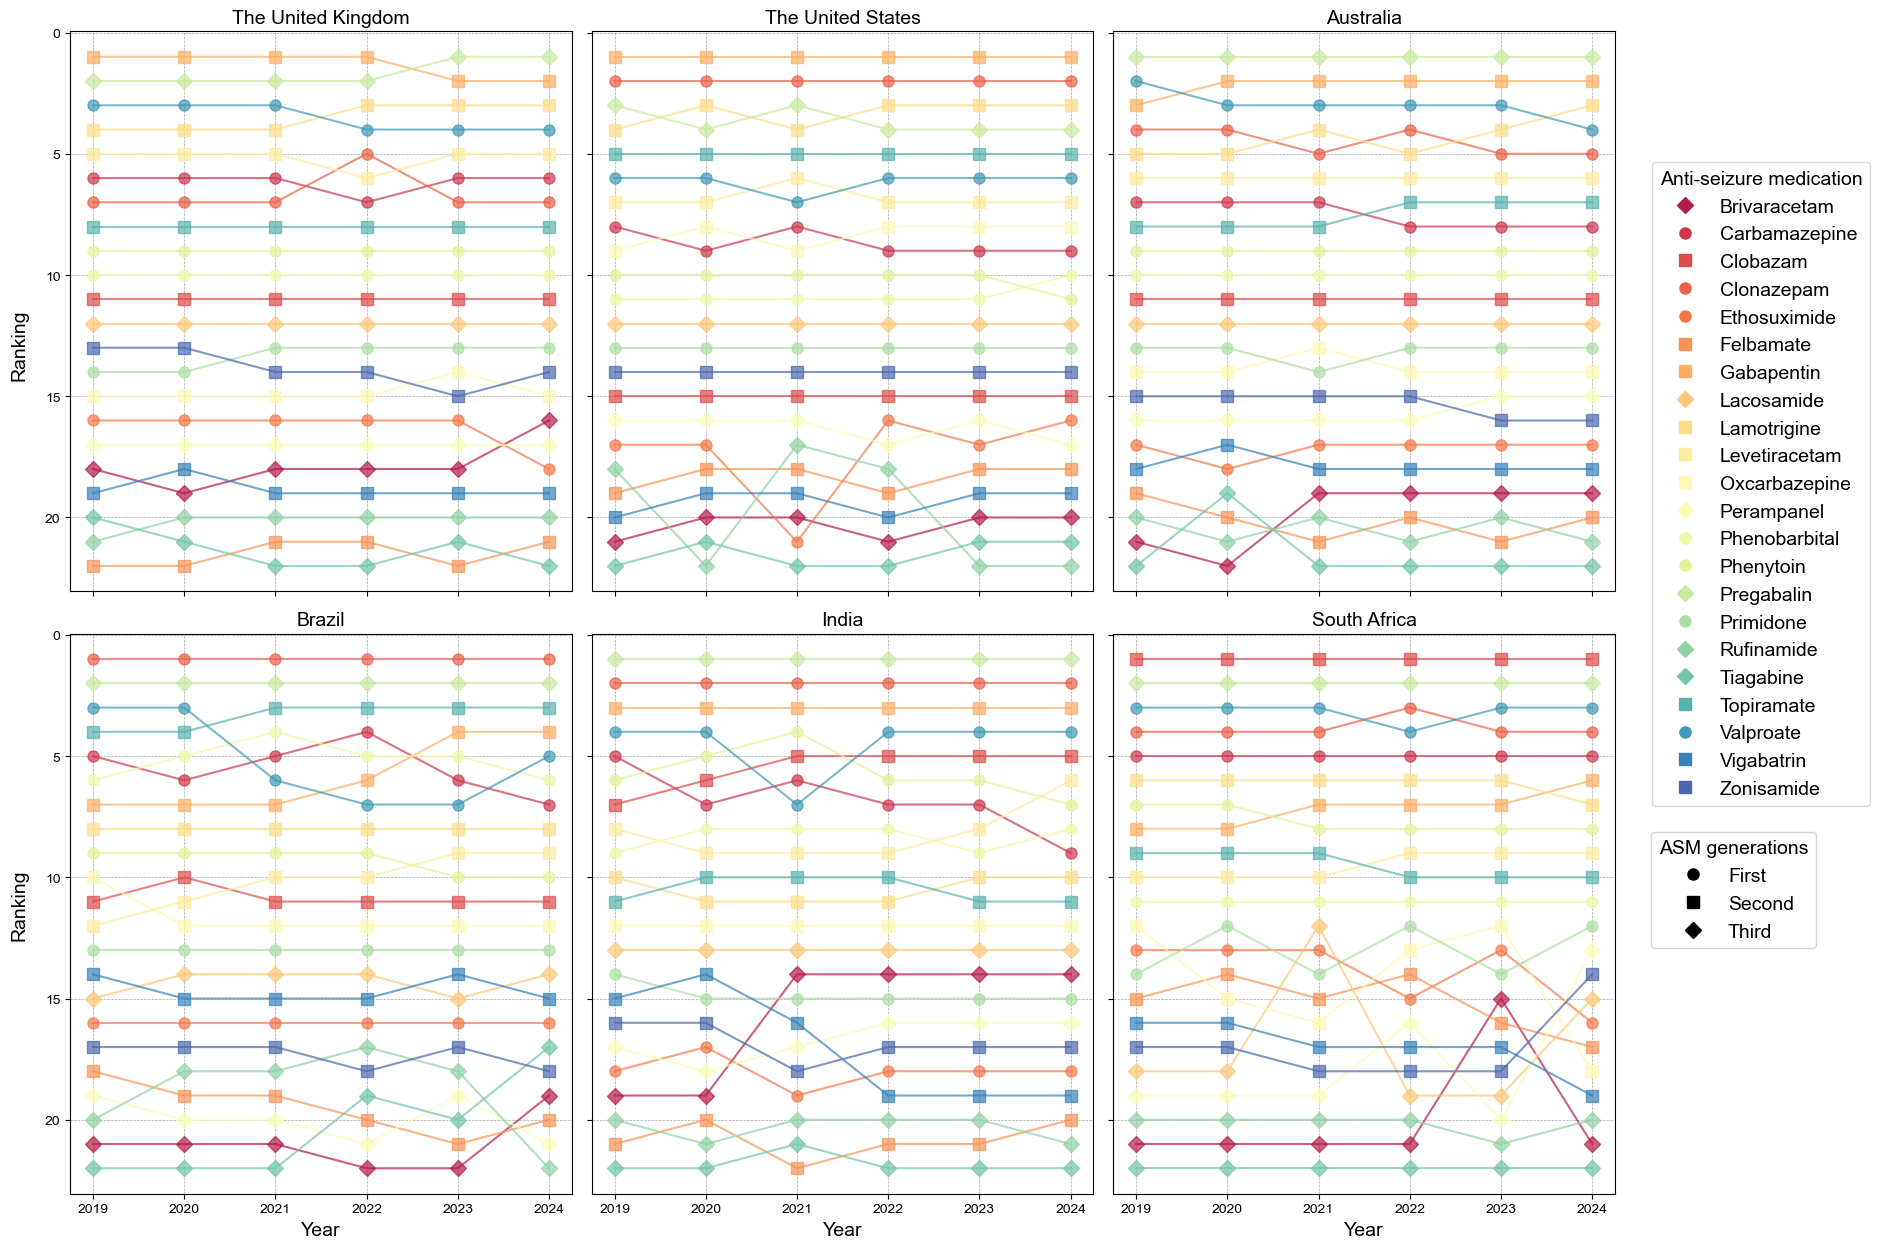

In [141]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.serif'] = ['Arial']

# Drug name mapping (Chinese-English correspondence)
medications = {
    "Carbamazepine": "卡马西平",
    "Clonazepam": "氯硝西泮",
    "Ethosuximide": "乙琥胺",
    "Phenobarbital": "苯巴比妥",
    "Phenytoin": "苯妥英",
    "Primidone": "乙苯嘧啶二酮",
    "Valproate": "丙戊酸",
    "Clobazam": "氯巴占",
    "Felbamate": "非尔氨酯",
    "Gabapentin": "加巴喷丁",
    "Lamotrigine": "拉莫三嗪",
    "Levetiracetam": "左乙拉西坦",
    "Oxcarbazepine": "奥卡西平",
    "Topiramate": "托吡酯",
    "Vigabatrin": "4-氨基-5-己烯酸",
    "Zonisamide": "唑尼沙胺",
    "Lacosamide": "拉科酰胺",
    "Pregabalin": "普瑞巴林",
    "Perampanel": "帕仑帕奈",
    "Rufinamide": "氟硝安定",
    "Brivaracetam": "布瓦西坦",
    "Tiagabine": "替加宾"
}

# Drug generation classification
drugs = [
    ("Gabapentin", "Second"),
    ("Clonazepam", "First"),
    ("Lamotrigine", "Second"),
    ("Pregabalin", "Third"),
    ("Topiramate", "Second"),
    ("Valproate", "First"),
    ("Levetiracetam", "Second"),
    ("Oxcarbazepine", "Second"),
    ("Carbamazepine", "First"),
    ("Phenobarbital", "First"),
    ("Phenytoin", "First"),
    ("Lacosamide", "Third"),
    ("Primidone", "First"),
    ("Zonisamide", "Second"),
    ("Clobazam", "Second"),
    ("Perampanel", "Third"),
    ("Ethosuximide", "First"),
    ("Vigabatrin", "Second"),
    ("Rufinamide", "Third"),
    ("Brivaracetam", "Third"),
    ("Tiagabine", "Third"),
    ("Felbamate", "Second"),
]

# Map drug generation into a dictionary
drug_generation = {drug: generation for drug, generation in drugs}

# Shape mapping for different generations
generation_markers = {
    "First": "o",   # Circle
    "Second": "s",  # Square
    "Third": "D"    # Diamond
}

# Use Seaborn color palette to assign colors to drugs
all_drugs_sorted = sorted([drug for drug, _ in drugs])
num_colors = len(all_drugs_sorted)
colors = sns.color_palette("Spectral", num_colors)
drug_colors = {drug: colors[i] for i, drug in enumerate(all_drugs_sorted)}

# Reverse the dictionary (map Chinese back to English)
medications_reverse = {v: k for k, v in medications.items()}


### Step 1: Process foreign data
def process_foreign_data():

    regions = {
        "uk": "The United Kingdom",
        "usa": "The United States",
        "au": "Australia",
        "bz": "Brazil",
        "in": "India",
        "sa": "South Africa",
    }

    yearly_rankings_per_region = {}

    for folder_suffix, country_name in regions.items():
        global_drug_values = {year: {drug: [] for drug in medications.keys()} for year in range(2019, 2025)}
        folder_path = f'../../data/google/ASMs/2019-2024/{folder_suffix}'  # Folder path
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(folder_path, file_name)
                df = pd.read_csv(file_path, skiprows=2)

                # Process column names to extract drug names
                df.columns = [medications_reverse.get(col.split(':')[0], col.split(':')[0]) for col in df.columns]

                # Convert '<1' to 0.1
                df.replace('<1', 0.1, inplace=True)
                df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

                # Extract year
                df['Year'] = pd.to_datetime(df.iloc[:, 0], errors='coerce').dt.year

                # Compute relative values
                for year, group in df.groupby('Year'):
                    base_drug = 'Clonazepam'
                    if base_drug not in group.columns:
                        continue
                    base_score = group[base_drug].mean()

                    for drug in group.columns[1:-1]:  # Skip date and year columns
                        relative_score = group[drug].mean()
                        if base_score != 0:
                            global_drug_values[year][drug].append(relative_score / base_score)

        # Compute rankings per country
        yearly_rankings = {}
        for year, drugs in global_drug_values.items():
            averaged_values = {drug: (sum(values) / len(values) if values else 0) for drug, values in drugs.items()}
            sorted_drugs = sorted(averaged_values.items(), key=lambda x: x[1], reverse=True)
            yearly_rankings[year] = sorted_drugs

        yearly_rankings_per_region[country_name] = yearly_rankings

    return yearly_rankings_per_region


### Step 2: Process Chinese data
def process_china_data():
    df = pd.read_excel('抗癫痫药物2019-2024排序 +index.xlsx')

    # Process date and drug names
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['keyword'] = df['keyword'].replace(medications_reverse)

    # Compute average value per drug per year
    df_avg = df.groupby(['keyword', 'year'])['all'].mean().reset_index()
    df_avg.rename(columns={'all': 'average'}, inplace=True)

    # Sort drugs by average value per year
    ranked_per_year = (
        df_avg.groupby('year')
        .apply(lambda x: x.sort_values('average', ascending=False).reset_index(drop=True))
        .reset_index(drop=True)
    )

    # Assign rank to each drug
    ranked_per_year['rank'] = ranked_per_year.groupby('year').cumcount() + 1

    return ranked_per_year


### Step 3: Plot ranking changes
def plot_rankings(country_name, yearly_rankings, output_file, flag):
    fig, ax = plt.subplots(figsize=(14, 8))  # Use plt.subplots to create fig and ax objects
    if flag == 1:
        for drug in all_drugs_sorted:
            years = []
            ranks = []
            for year, rankings in yearly_rankings.items():
                drug_rank = next((i + 1 for i, (name, _) in enumerate(rankings) if name == drug), None)
                if drug_rank:
                    years.append(year)
                    ranks.append(drug_rank)

            if years and ranks:
                generation = drug_generation.get(drug, "Unknown")
                marker = generation_markers.get(generation, "x")
                plt.plot(years, ranks, marker=marker, label=drug, color=drug_colors[drug], alpha=0.7, markersize=8)
        # Invert y-axis to place rank 1 at the top
        plt.gca().invert_yaxis()
        plt.xlabel('Year', fontsize=14)
        plt.ylabel('Ranking', fontsize=14)
        plt.title(f'{country_name}', fontsize=14)

        # Create legend for drugs
        drug_handles = [
            plt.Line2D([], [], color=drug_colors[drug], marker=generation_markers[drug_generation[drug]],
                       linestyle='None', markersize=8, label=drug)
            for drug in all_drugs_sorted
        ]

        # Create legend for generations
        generation_handles = [
            plt.Line2D([], [], marker=marker, color='black', linestyle='None', markersize=8, label=f"{generation}")
            for generation, marker in generation_markers.items()
        ]

        # Add combined legend (drugs and generations)
        fig.legend(handles=drug_handles, loc='center right', bbox_to_anchor=(0.96, 0.66), fontsize=10,
                   title="Anti-seizure medication", ncol=1)
        fig.legend(handles=generation_handles, loc='center right', bbox_to_anchor=(0.923, 0.3), fontsize=10,
                   title="ASM generations", ncol=1)

        plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
        plt.tight_layout(rect=[0, 0, 0.8, 1])
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

    else:
        # Filter drugs that actually exist in the Chinese data
        existing_drugs = yearly_rankings['keyword'].unique()

        for drug in existing_drugs:
            years = yearly_rankings[yearly_rankings['keyword'] == drug]['year']
            ranks = yearly_rankings[yearly_rankings['keyword'] == drug]['rank']

            generation = drug_generation.get(drug, "Unknown")
            marker = generation_markers.get(generation, "x")
            color = drug_colors.get(drug, "#000000")

            plt.plot(years, ranks, marker=marker, label=drug, color=color, alpha=0.7, markersize=8, linestyle='-')

        plt.gca().invert_yaxis()
        plt.xlabel('Year', fontsize=14)
        plt.ylabel('Ranking', fontsize=14)
        plt.title(f'{country_name}', fontsize=14)

        drug_handles = [
            plt.Line2D([], [], color=drug_colors[drug], marker=generation_markers[drug_generation[drug]],
                       linestyle='None', markersize=8, label=drug)
            for drug in existing_drugs
        ]

        generation_handles = [
            plt.Line2D([], [], marker=marker, color='black', linestyle='None', markersize=8, label=f"{generation}")
            for generation, marker in generation_markers.items()
        ]

        fig.legend(handles=drug_handles, loc='center right', bbox_to_anchor=(0.95, 0.833), fontsize=10,
                   title="Anti-seizure medication", ncol=1)
        fig.legend(handles=generation_handles, loc='center right', bbox_to_anchor=(0.912, 0.64), fontsize=10,
                   title="ASM generations", ncol=1)

        plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
        plt.tight_layout(rect=[0, 0, 0.80, 1])
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()


def plot_panel_figures(foreign_rankings, output_file):
    # Create 2x3 grid of subplots
    fig, axes = plt.subplots(2, 3, figsize=(20, 14), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, (country, yearly_rankings) in enumerate(foreign_rankings.items()):
        ax = axes[i]
        for drug in all_drugs_sorted:
            years = []
            ranks = []
            for year, rankings in yearly_rankings.items():
                drug_rank = next((i + 1 for i, (name, _) in enumerate(rankings) if name == drug), None)
                if drug_rank:
                    years.append(year)
                    ranks.append(drug_rank)

            if years and ranks:
                generation = drug_generation.get(drug, "Unknown")
                marker = generation_markers.get(generation, "x")
                ax.plot(years, ranks, marker=marker, label=drug, color=drug_colors[drug], alpha=0.7, markersize=8)

        ax.set_title(country, fontsize=14)
        ax.invert_yaxis()

    for col in range(3):
        ax = axes[3 + col]
        ax.set_xlabel('Year', fontsize=14)

    fig.text(0.04, 0.7, 'Ranking', va='center', rotation='vertical', fontsize=14)
    fig.text(0.04, 0.3, 'Ranking', va='center', rotation='vertical', fontsize=14)

    for ax in axes:
        ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

    drug_handles = [
        plt.Line2D([], [], color=drug_colors[drug], marker=generation_markers[drug_generation[drug]],
                   linestyle='None', markersize=8, label=drug)
        for drug in all_drugs_sorted
    ]

    generation_handles = [
        plt.Line2D([], [], marker=marker, color='black', linestyle='None', markersize=8, label=f"{generation}")
        for generation, marker in generation_markers.items()
    ]

    fig.legend(handles=drug_handles, loc='center right', bbox_to_anchor=(0.975, 0.6), fontsize=14,
               title="Anti-seizure medication", title_fontsize=14, ncol=1)
    fig.legend(handles=generation_handles, loc='center right', bbox_to_anchor=(0.948, 0.31), fontsize=14,
               title="ASM generations", title_fontsize=14, ncol=1)

    plt.gca().invert_yaxis()
    plt.tight_layout(rect=[0.05, 0.05, 0.85, 0.95])
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()


foreign_rankings = process_foreign_data()

# Plot panel chart
plot_panel_figures(foreign_rankings, './pics/drug_ranking_foreign_panel.tiff')
